In [34]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [35]:
def detect_abnormal_activity(df,
                             reference_date,
                             volume_zscore_threshold=2.0,
                             returns_zscore_threshold=2.0):
    """
    Detect abnormal volume or returns in the 30 days leading up to `reference_date`,
    based on statistics computed from the prior 180 days (which ends 30 days before `reference_date`).

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing at least ['Date', 'Close', 'Volume'] columns.
    reference_date : str or pd.Timestamp
        The reference date around which we analyze data. 
        (For best practice, pass a string in 'YYYY-MM-DD' format or a pandas Timestamp.)
    volume_zscore_threshold : float, optional
        Z-score threshold for flagging abnormal volume. Default is 2.0.
    returns_zscore_threshold : float, optional
        Z-score threshold for flagging abnormal returns. Default is 2.0.

    Returns
    -------
    pd.DataFrame
        A copy of the DataFrame (restricted to the last 30-day analysis period)
        with additional columns:
        ['Daily_Returns', 'Volume_Zscore', 'Returns_Zscore', 
         'Abnormal_Volume', 'Abnormal_Returns'].
    """
    # 1. Convert Date column to datetime if needed
    df['Date'] = pd.to_datetime(df['Date'])
    
    # 2. Sort DataFrame by date (ascending)
    df = df.sort_values('Date').reset_index(drop=True)
    
    # 3. Calculate daily returns
    df['Daily_Returns'] = df['Close'].pct_change()
    
    # Convert reference_date to Timestamp
    ref_date = pd.to_datetime(reference_date)
    
    # Define the two date ranges:
    # Historical period: [ref_date - 210 days, ref_date - 30 days)
    start_hist = ref_date - pd.Timedelta(days=210)
    end_hist = ref_date - pd.Timedelta(days=30)
    
    # Analysis period: [ref_date - 30 days, ref_date)
    start_analysis = ref_date - pd.Timedelta(days=30)
    end_analysis = ref_date
    
    # 4. Filter the historical period
    mask_hist = (df['Date'] >= start_hist) & (df['Date'] < end_hist)
    df_hist = df.loc[mask_hist]
    
    # 5. Compute mean & std for volume and daily returns in the historical period
    vol_mean = df_hist['Volume'].mean()
    vol_std = df_hist['Volume'].std()
    
    returns_mean = df_hist['Daily_Returns'].mean()
    returns_std = df_hist['Daily_Returns'].std()
    
    # 6. Filter the analysis period
    mask_analysis = (df['Date'] >= start_analysis) & (df['Date'] < end_analysis)
    df_analysis = df.loc[mask_analysis].copy()
    
    # 7. Compute z-scores for volume and daily returns in the analysis period
    #    (Handle the case where std could be zero to avoid division by zero)
    if vol_std == 0:
        df_analysis['Volume_Zscore'] = 0
    else:
        df_analysis['Volume_Zscore'] = (df_analysis['Volume'] - vol_mean) / vol_std
    
    if returns_std == 0:
        df_analysis['Returns_Zscore'] = 0
    else:
        df_analysis['Returns_Zscore'] = (df_analysis['Daily_Returns'] - returns_mean) / returns_std
    
    # 8. Flag any day with volume or returns outside the chosen threshold
    df_analysis['Abnormal_Volume'] = df_analysis['Volume_Zscore'].abs() > volume_zscore_threshold
    df_analysis['Abnormal_Returns'] = df_analysis['Returns_Zscore'].abs() > returns_zscore_threshold
    
    # Return the analysis period with the new columns
    return df_analysis
    

In [36]:
detect_abnormal_activity(pd.read_excel("INFOSYS_data.xlsx"), '2019-10-11')

,Unnamed: 0,Date,Close,High,Low,Open,Volume,Daily_Returns,Volume_Zscore,Returns_Zscore,Abnormal_Volume,Abnormal_Returns
1133,1133,2019-09-11,713.108643,720.456255,707.934930,715.021638,7981036,-0.010855,-0.007924,-0.933806,False,False
1134,1134,2019-09-12,709.891418,712.891285,705.065436,709.891418,4400017,-0.004512,-0.848799,-0.456404,False,False
1135,1135,2019-09-13,721.108398,722.630091,710.847853,711.369555,4832021,0.015801,-0.747358,1.072274,False,False
1136,1136,2019-09-16,719.717224,728.629996,713.500001,723.499696,4846496,-0.001929,-0.743959,-0.262063,False,False
1137,1137,2019-09-17,722.804138,726.064909,713.500062,723.021523,5540901,0.004289,-0.580903,0.205911,False,False
1138,1138,2019-09-18,721.586731,724.282333,716.499950,721.630250,3199389,-0.001684,-1.130723,-0.243630,False,False
1139,1139,2019-09-19,713.630371,719.108454,708.847909,717.238925,6601607,-0.011026,-0.331834,-0.946683,False,False
1140,1140,2019-09-20,699.978638,726.064798,697.370022,715.543401,22462366,-0.019130,3.392498,-1.556557,True,False
1141,1141,2019-09-23,664.631958,701.630876,645.110854,701.630876,17279260,-0.050497,2.175431,-3.917158,True,True
1142,1142,2019-09-24,690.457275,694.457186,665.197184,665.197184,13717998,0.038857,1.339196,2.807390,False,True


In [37]:
def detect_abnormal_monthly_move(
    df,
    reference_date,
    volume_zscore_threshold=1,
    return_zscore_threshold=1
):
    """
    Check if the *entire 30-day period* before `reference_date` is abnormal,
    by comparing:
      - total volume in that 30-day window
      - total (cumulative) return over that 30-day window
    against a distribution of 30-day windows from the prior 180 days.

    Returns two booleans:
      any_abnormal_volume   (bool)
      any_abnormal_return   (bool)
    """

    # 1. Make sure Date is datetime; sort ascending
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # 2. Convert reference_date to Timestamp
    ref_date = pd.to_datetime(reference_date)

    # 3. Define the analysis window: last 30 days
    analysis_start = ref_date - pd.Timedelta(days=30)
    analysis_end   = ref_date  # you can decide whether to include this date or not

    # Mask for analysis window
    mask_analysis = (df['Date'] >= analysis_start) & (df['Date'] < analysis_end)
    df_analysis = df.loc[mask_analysis]

    # 4. Compute aggregates for the analysis window
    # -- (a) Sum of volume
    analysis_volume_sum = df_analysis['Volume'].sum()

    # -- (b) 30-day return: (Close at end / Close at start) - 1
    # We'll define "start" as the first row in df_analysis and "end" as the last row
    # (some 1-2 day offset might occur if that date is not in the data, but typically it's close enough)
    if not df_analysis.empty:
        close_start = df_analysis['Close'].iloc[0]
        close_end   = df_analysis['Close'].iloc[-1]
        analysis_return_30d = (close_end / close_start) - 1
    else:
        # Edge-case: If no rows in analysis window, can't compute
        analysis_return_30d = 0.0

    # 5. Define historical window: prior 180 days (that end 30 days before ref_date)
    hist_start = ref_date - pd.Timedelta(days=210)
    hist_end   = ref_date - pd.Timedelta(days=30)

    # Filter historical period
    df_hist = df[(df['Date'] >= hist_start) & (df['Date'] < hist_end)].copy()

    # Edge-case: if there's insufficient historical data, handle gracefully
    if df_hist.shape[0] < 30:
        # Not enough data to form 30-day windows
        return (False, False)

    # 6. For each possible 30-day sub-window in the historical period, compute:
    #    - sum of volume
    #    - 30-day return
    # We will build distributions of these aggregates, then compute mean+std.

    volume_sums = []
    returns_30d = []

    # We'll iterate over each date in df_hist. For each date `d`,
    # find the 30-day slice [d, d+30). If that slice is fully within the historical window, compute aggregates.

    # Approach: We'll do this by index, not by exact calendar date, to avoid gaps.
    # Another approach is truly rolling by calendar date. For simplicity, let's do a "sliding window" by index.

    hist_dates = df_hist['Date'].values
    for i in range(len(df_hist)):
        start_date_i = df_hist.iloc[i]['Date']
        end_date_i   = start_date_i + pd.Timedelta(days=30)
        
        # We want all rows between start_date_i (inclusive) and end_date_i (exclusive)
        mask_30d = (df_hist['Date'] >= start_date_i) & (df_hist['Date'] < end_date_i)
        df_window = df_hist[mask_30d]

        # If the window has at least, say, ~20 trading days, consider it valid
        # or you can require full 30 calendar days. Here let's just check length.
        if len(df_window) < 5:
            # Skip windows too small to be meaningful
            continue

        # sum of volume
        vol_sum = df_window['Volume'].sum()
        volume_sums.append(vol_sum)

        # monthly return = (Close at end / Close at start) - 1
        close_start_ = df_window['Close'].iloc[0]
        close_end_   = df_window['Close'].iloc[-1]
        monthly_ret  = (close_end_ / close_start_) - 1
        returns_30d.append(monthly_ret)

    # If we didn't get any valid windows, fallback
    if not volume_sums:
        return (False, False)

    # 7. Compute mean and std from the historical distribution
    vol_mean = np.mean(volume_sums)
    vol_std  = np.std(volume_sums, ddof=1)  # sample std

    ret_mean = np.mean(returns_30d)
    ret_std  = np.std(returns_30d, ddof=1)

    # 8. Compute z-score for the single 30-day analysis window
    #    volume sum
    if vol_std == 0:
        z_vol = 0
    else:
        z_vol = (analysis_volume_sum - vol_mean) / vol_std

    #    monthly return
    if ret_std == 0:
        z_ret = 0
    else:
        z_ret = (analysis_return_30d - ret_mean) / ret_std

    # 9. Decide if these are abnormal
    is_abnormal_volume = abs(z_vol) > volume_zscore_threshold
    is_abnormal_return = abs(z_ret) > return_zscore_threshold

    return is_abnormal_volume, is_abnormal_return, z_vol, z_ret

In [38]:
date = '2019-10-11'
detect_abnormal_monthly_move(pd.read_excel("INFOSYS_data.xlsx"), date)

(False, True, 0.5643970135076118, -1.6787887430482096)

In [78]:
def volume_analysis(df, x):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    results = {}
    
    n = len(df)
    for i in range(0, 1000, x):
        # Take a slice of length x
        chunk = df.iloc[i:i+x]
        
        if chunk.empty:
            break

        # End date of the chunk is the last Date in this slice
        end_date = chunk['Date'].iloc[-1].strftime('%Y-%m-%d')
        # Compute average volume over this slice
        avg_volume = chunk['Volume'].mean()

        
        
        results[end_date] = avg_volume

    return results

In [82]:
avg_vol = volume_analysis(pd.read_excel("CIPLA_data.xlsx"),30)

In [83]:
def plot_volume(avg_vol_dict):
    plot_df = pd.DataFrame({
        'EndDate': list(avg_vol_dict.keys()),
        'AvgVolume': list(avg_vol_dict.values())})
    plot_df['EndDate'] = pd.to_datetime(plot_df['EndDate'])
    plt.figure(figsize=(10,6))
    plt.plot(plot_df['EndDate'], plot_df['AvgVolume'], marker='o', linestyle='-')
    
    plt.xlabel('End Date of the day Window')
    plt.ylabel('Average Volume')
    plt.title('Average x-Day Volume Over Time')
    
    # Make the x-axis labels easier to read
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    

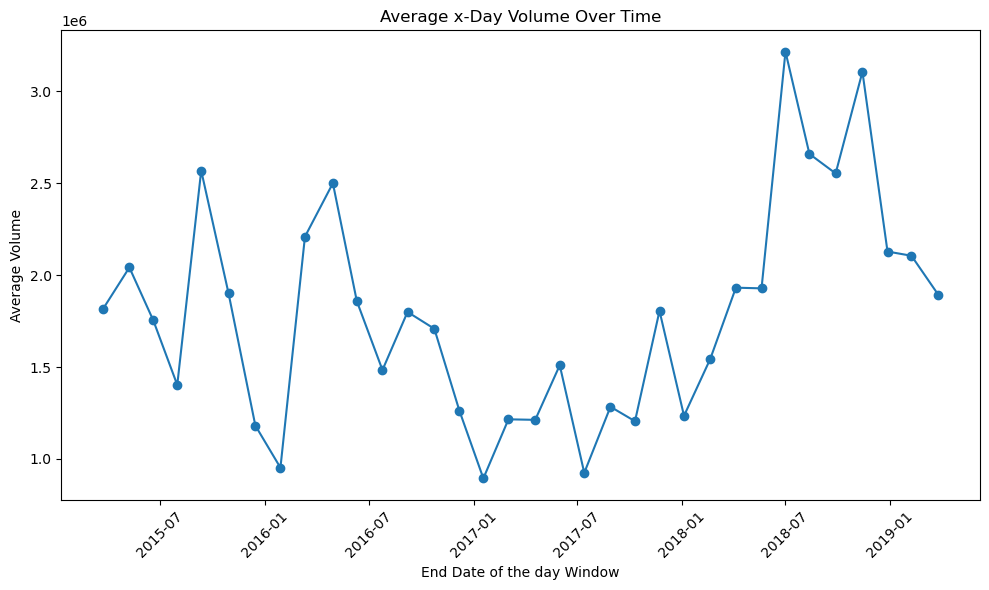

In [84]:
plot_volume(avg_vol)